# <center>Assignment 1</center>

In this assignment, you will build a reasonably self-sufficient Custom AutoDiff and test the same by comparing your output against an identical Feed-forward neural network implemented using Tensorflow. Later, you will perform a set of experiments to get a better feel of:
- the difficulties in optimizing certain Neural Network Architectures. 
- solutions for improving the performance. 
- the sensitivity to learning-rate in certain Architectures, etc. 

We will use the MNIST data for the purposes of this assignment. 

There are 2 main varieties of coding tasks:
- You will either be given a partially coded function describing what it should do and you should code the same.
OR
- You will be given an already completed function and asked to describe what it does. In such cases, please answer in less than 10 words. 

Marks:

<table>
  <tr>
    <td><b>Section</b></td>
    <td><b>Score</b></td>
  </tr>
  <tr>
    <td> Completing CustomAutoDiff.py </td>
    <td> 10 </td>
  </tr>
  <tr>
    <td> Answering the questions in comments </td>
    <td> 5 </td>
  </tr>
    <tr>
    <td> Running Experiments </td>
    <td> 10 </td>
  </tr>
  <tr>
    <td> <b>Total</b>  </td>
    <td> 25 </td>
  </tr>
  </table>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import random 
import tensorflow as tf
import numpy as np
tf.__version__

'1.13.1'

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

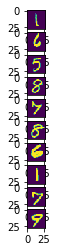

In [0]:
# Load MNIST Data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)
print(train_data.shape)
print(train_labels.shape)
print(eval_data.shape)
print(eval_labels.shape)
# Randomly choose 10 images from first 50 images of Train Data.
for index,idx in enumerate(random.sample(range(50),10)): 
    plt.subplot(10,1,index+1)
    plt.imshow(train_data[idx].reshape(28,28))

## Custom AutoDiff

The skeleton code for the Custom AutoDiff is given in the file CustomAutoDiff.py. The first part of the assignment is to fill in the `backward` and `__init__` functions of the various Operations. 

The following is the quick summary of the features and limitations:
- Every node in the graph is considered a Variable. This means that the gradient will be computed with respect to "constants" (Ex: inputs,outputs,etc) even though we do not need the gradients. 
- Every Variable should be represented as a 2D array. A scalar is automatically converted to a 2D array as required. 
- The following lists the set of supported operations and their syntax:
    * $e^\mathbf{x}$ => `x.exp()`
    * $log(\mathbf{x})$ => `x.log()`
    * Matrix-Addition (allows broadcasting) => `x + y`
    * Elementwise-Multiplication (allows broadcasting) => `x * y`
    * Elementwise-Division (allows broadcasting) => `x/y`
    * Matrix-Multiplication => `x @ y`
    * Sum along the dimension D => `x.reduce_sum(axis=D)`
        - Allows only 1 axis at a time.
        - All operations retain the rank of x.
    * Activation Functions (Sigmoid, Tanh, ReLU): `ReLU(x)`
- Automatically converts a numpy object/list/scalar into a `Variable`. However, the first operand of the operation should be a `Variable`. If `x = Variable([[1,2,3]])`:
    * `x+10` is valid.
    * `10+x` is not! (Why?) 

In [0]:
%load_ext autoreload
%autoreload 2

# The autoreload helps in automatically reloading the module as soon as 
# it changes on the disk. 
import CustomAutoDiff as cad

In [0]:
%reload_ext autoreload

In [0]:
def test():
    """
    Tests MatrixMultiplication.
    """
    v1 = cad.Variable([[1,2],
                       [3,4]])
    v2 = cad.Variable([[1],
                       [3]])
    
    mult_ = v1 @ v2
    print("MatMul")
    print(mult_.value)
    
    mult_.gradient = np.array([[1],
                               [3]])
    
    mult_.backward()
    
    print("Derivatives")
    print(v1.gradient)
    print(v2.gradient)
test()

MatMul
[[ 7.]
 [15.]]
Derivatives
[[1. 3.]
 [3. 9.]]
[[10.]
 [14.]]


In [0]:
def test():
    """
    Tests MatrixAddition (Broadcasting).
    Check by transposing v2 as well.
    """
    v1 = cad.Variable([[1,2],
                       [3,4]])
    v2 = cad.Variable([[1],
                       [3]])
    # Repeat the test by uncommenting the next line.
    #v2.value = v2.value.T 
    sum_ = v1 + v2
    print("Sum")
    print(sum_.value)
    
    sum_.gradient = np.array([[1,0],
                              [0,3]])
    
    sum_.backward()
    print("Derivatives")
    print(v1.gradient)
    print(v2.gradient)    
test()

Sum
[[2. 3.]
 [6. 7.]]
Derivatives
[[1 0]
 [0 3]]
[[1]
 [3]]


In [0]:
def test():
    """
    Tests reduce_sum, log, exp, MatrixDivision and ElementwiseMultiplication.
    """
    v = cad.Variable([[1,2,3],
                      [3,10,5]])
    sm = v.exp()/v.exp().reduce_sum(axis=1)
    print("Softmax output")
    print(sm.value)
    
    loss = (sm.log()*([[0,1,0],
                      [1,0,0]])).reduce_sum(axis=0).reduce_sum(axis=1)
    print("Loss")
    print(loss.value)
    
    loss.gradient = 1
    loss.backward()
    
    print("Derivative wrt softmax")
    print(sm.gradient)
    
    print("Derivative wrt logits")
    print(v.gradient)
test()

Softmax output
[[9.00305732e-02 2.44728471e-01 6.65240956e-01]
 [9.04959183e-04 9.92408247e-01 6.68679417e-03]]
Loss
[[-8.41522668]]
Derivative wrt softmax
[[   0.            4.08616127    0.        ]
 [1105.02221453    0.            0.        ]]
Derivative wrt logits
[[-0.09003057  0.75527153 -0.66524096]
 [ 0.99909504 -0.99240825 -0.00668679]]


In [0]:
activation_map = {
    "sigmoid": [cad.Sigmoid,tf.sigmoid],
    "relu": [cad.ReLU,tf.nn.relu],
    "tanh": [cad.Tanh,tf.tanh]
}

## Custom NN

Already done for you, answer the questions in the comments. 

In [0]:
class CustomNN:
    def __init__(self,conf):
        self.weights = [cad.Variable(weight) for weight in conf.weights]
        self.biases = [cad.Variable(bias) for bias in conf.biases]
        self.activations = [activation_map[activation][0] for activation in conf.activations]
        self.learning_rate = conf.learning_rate
        self.mu = conf.momentum
        
    def forward(self,batch):
        # Describe what the following function does. 
        '''
        The function use for loop to iterate each weight, bias and activations that are zip together.
        it also define the logits and softmax function when foward pass. 
        This is similar to building the computation graph in Tensorflow.
        '''
        temp = cad.Variable(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        logits = temp@self.weights[-1]+self.biases[-1]
        softmax = logits.exp()/logits.exp().reduce_sum(axis=1)
        return logits.value
    
    def loss_and_gradients(self,batch,targets):
        for param in self.weights+self.biases:
            param.reset()
            
        temp = cad.Variable(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        
        logits = temp@self.weights[-1]+self.biases[-1]
        
        # Why do we do this? 
        '''
        The reason we do this is to stable network in an numerical way. 
        In softmax the exponential function increases very fast, 
        to increase the stability we can subtract the maximum value withou make change to the softmax result. 
        '''
        logits = logits + (-logits.value.max(axis=1,keepdims=True))
        softmax = logits.exp()/logits.exp().reduce_sum(axis=1)
        
        # Why did we add 10**-6 to softmax?
        '''
        We add this is because we want to control the percision of the results
        '''
        # Why did we multiply with "-targets"?
        '''
        This looks like the Cross Entropy loss to me, the functiong is defined like this, 
        so that  the reason we multiply with negative target.
        or in an neumerical way we could say we want our loss to be positive 
        softmax is a decimal number between 0 and 1 the log of it would be negative,
        if we want to get positive loos we multiply a negative number which is the negative of target. 
        '''
        loss = ((softmax+10**-6).log() * cad.Variable(-targets)).reduce_sum(axis=0).reduce_sum(axis=1)/batch.shape[0]
        
        loss.gradient = 1
        loss.backward()
        return {
            "loss" :loss.value,
            "grads":[param.gradient for param in (self.weights+self.biases)]
        }
    
    def apply_gradients(self):
        #initial velocity is zero
        v = 0
        for param in self.weights+self.biases:
            param.value -= self.learning_rate * param.gradient
            
            param.reset()

## Tensorflow NN

Already done for you, answer the questions in the comments. 

In [0]:
class TensorflowNN:
    def __init__(self,conf):
        # Why is it a good idea to build the compute graph within the tf.Graph scope?
        '''
        1: Tensorflow's session will caches information about the graph
        2: For parallesims, differetn part of the graph can run in parallel to save computation time. 
        '''
        g = tf.Graph()
        with g.as_default():
            # Define the placeholders
            self.input = tf.placeholder(dtype=tf.float64, shape=(None, 784))
            self.expected_output = tf.placeholder(dtype=tf.float64, shape=(None, 10))
            
            self.weights = [tf.Variable(dtype=tf.float64,initial_value=weight) for weight in conf.weights]
            self.biases = [tf.Variable(dtype=tf.float64,initial_value=bias) for bias in conf.biases]

            # Build the graph for computing output.
            layer = self.input
            for i in range(0, len(conf.activations)):
                layer = layer@self.weights[i] + self.biases[i]
                layer = activation_map[conf.activations[i]][1](layer)
            
            # For output layer
            self.logits = layer@self.weights[-1] + self.biases[-1]
            logits = self.logits - tf.reduce_max(self.logits,axis=1,keepdims=True)
            
            self.output = tf.exp(logits)/tf.reduce_sum(tf.exp(logits),axis=1,keepdims=True)
            self.loss = -tf.reduce_mean(tf.reduce_sum(tf.log(self.output+10**-6)*self.expected_output,axis=1))
            
            # Instantiate the optimizer
            #self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf.learning_rate)
            self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf.learning_rate)
            
            self.grads = self.optimizer.compute_gradients(self.loss)
            self.train_op = self.optimizer.apply_gradients(self.grads)
            
            self.session = tf.Session()
            
            # Initialize all variables
            self.session.run(tf.global_variables_initializer())
    
    def forward(self,batch):
        return self.session.run(self.logits,feed_dict={self.input:batch})
    
    def loss_and_gradients(self,batch,targets):
        return {
            "loss" :self.session.run(self.loss,feed_dict={self.input:batch,self.expected_output:targets}),
            "grads":self.session.run(tf.gradients(self.loss,self.weights+self.biases),feed_dict={self.input:batch,self.expected_output:targets})
        }
    
    def apply_gradients(self,batch,targets):
        self.session.run(self.train_op,feed_dict={self.input:batch,self.expected_output:targets})

## Comparing Custom NN and Tensorflow NN

Just run the following code snippets after filling out CustomAutoDiff.py.

Preparing weights

In [0]:
class Conf:
    def __init__(self,hidden_layers,activations,learning_rate,momentum):
        number_units = [784] + hidden_layers + [10]
        weights = []
        biases = []
        for prev,curr in zip(number_units,number_units[1:]):
            np.random.seed(1)
            weights.append(np.random.randn(prev,curr))
            biases.append(np.zeros([1,curr],dtype=np.float32))
        self.weights = weights
        self.biases = biases
        self.activations = activations
        self.learning_rate = learning_rate

conf = Conf(hidden_layers=[300],
           activations=["sigmoid"],
           learning_rate=0.1)
"""
Let's create two instances of the above Neural Network configuration - 
one built on custom AutoDiff framework and the other built on Tensorflow Library. 
"""

customNN = CustomNN(conf)
tensorNN = TensorflowNN(conf)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


We will first make sure that our code is correct by comparing the results against that of Tensorflow's. 

<b>Comparing forward pass</b>

In [0]:
idx = random.choice(range(len(train_data)))
t1 = customNN.forward(train_data[idx:idx+5])
t2 = tensorNN.forward(train_data[idx:idx+5])
print((np.abs(t2-t1)<10**-6).all())

True


<b>Comparing Gradients</b>

In [0]:

idx = random.choice(range(train_data.shape[0]))
t1 = customNN.loss_and_gradients(train_data[idx:idx+5],train_labels[idx:idx+5])
t2 = tensorNN.loss_and_gradients(train_data[idx:idx+5],train_labels[idx:idx+5])
print(t1["loss"],t2["loss"])
for i,j in zip(t1["grads"],t2["grads"]):
   
    print((np.abs(j-i)<10**-6).all())

[[13.59392699]] 13.593926991094104
True
True
True
True


<b>Comparing Test Accuracies for 10 steps of training </b>

In [0]:
for epoch in range(10):
    for idx in range(0,train_data.shape[0],128):
        # TensorNN update
        tensorNN.apply_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
        
        # CustomNN update
        loss_and_grads1 = customNN.loss_and_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
        customNN.apply_gradients()
    
    tensorNN_correct = 0
    customNN_correct = 0
    for idx in range(0,eval_data.shape[0],128):
        expected = eval_labels[idx:idx+128]
        
        # TensorNN Accuracy
        preds = tensorNN.forward(eval_data[idx:idx+128])
        tensorNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()
        
        # CustomNN Accuracy
        preds = customNN.forward(eval_data[idx:idx+128])
        customNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()
    
    print("Epoch {}: {} {}".format(epoch,tensorNN_correct/eval_data.shape[0],customNN_correct/eval_data.shape[0]))

Epoch 0: 0.7526 0.7526
Epoch 1: 0.8178 0.8178
Epoch 2: 0.8454 0.8454
Epoch 3: 0.86 0.86
Epoch 4: 0.8702 0.8702
Epoch 5: 0.8795 0.8795
Epoch 6: 0.8845 0.8845
Epoch 7: 0.8894 0.8894
Epoch 8: 0.8942 0.8942
Epoch 9: 0.8971 0.8971



Now that you have been able to successfully reproduce Tensorflow Results using a custom framework, answer the following questions [Each question is worth 2 points. If you answer the questions 2 and 4 exceptionally well, you can get upto 3 additional points for each of them and not answer the other questions.]:
<ol>
<li>Try out a few configurations of NNs by increasing hidden units, adding layers, changing activation functions, etc; for the configurations you try, what was the best possible performance you were able to achieve by adjusting the learning-rate? Use either the CustomNN or the TensorflowNN for future experiments (unless you want to validate your code). </li>
<li> Does scaling down the initial parameters affect the learning curve? In other words, you use ``np.random.randn(prev,curr)/K``(K>>1) instead of ``np.random.randn(prev,curr)``. Did you observe this uniformly across sigmoid, tanh and relu? Did you find any correlation with the number of hidden units? Explain. </li>
<li> Did you come across any configurations which got stuck in a saddle point and progressed very slowly, yielding a below-normal accuracy in about 50 epochs (despite adjusting the learning-rate)? These networks can be trained better by the use of Momentum. Implement an additional method in the CustomNN class which can perform the momentum update. Use the TensorflowNN class to validate your code; you can add another optimizer object to the TensorflowNN class. Add an additional attribute to the Conf class that controls the momentum. </li>
<li> For only one such configuration, demonstrate the improvement that you can get by using momentum by plotting the learning curve. </li> 
<li> What was the best accuracy you were able to get in 10 epochs of training? What was the corresponding config?</li>
 </ol>

###Question 1

<li>Try out a few configurations of NNs by increasing hidden units, adding layers, changing activation functions, etc; for the configurations you try, what was the best possible performance you were able to achieve by adjusting the learning-rate? Use either the CustomNN or the TensorflowNN for future experiments (unless you want to validate your code). </li>

In [0]:
def training(lr,conf,num_epoch):
  conf.learning_rate = lr
  print("Current learning rate:",conf.learning_rate)
  tensorNN = TensorflowNN(conf)
  accuracy = np.zeros(num_epoch)
  
  for epoch in range(num_epoch):
      for idx in range(0,train_data.shape[0],128):
          # TensorNN update
          tensorNN.apply_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
      tensorNN_correct = 0
      for idx in range(0,eval_data.shape[0],128):
          expected = eval_labels[idx:idx+128]

          # TensorNN Accuracy
          preds = tensorNN.forward(eval_data[idx:idx+128])
          tensorNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()

      #print("Epoch {}: {}".format(epoch,tensorNN_correct/eval_data.shape[0]))
      accuracy[epoch] = tensorNN_correct/eval_data.shape[0]
  return accuracy,accuracy[-1]

<b> Start experiment</b>

<b>Tanh:</b>

In [0]:
#update config
number_of_epoch = 500 #more epoch trying to get best results
conf.activations = ["tanh"]
conf.hidden_layers = [300]

#initialize model
tensorNN = TensorflowNN(conf)

#initialize output
accuracy_relu_q1 = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve_relu_q1 = np.zeros((10,number_of_epoch))

for i in range(1,10):
  learning_curve_tanh_q1[i-1],accuracy_tanh_q1[i-1] = training(i/10,conf,number_of_epoch)
  #print("accuracy: ",learning_curve[i-1])
  print("accuracy:",accuracy_tanh_q1[i-1])

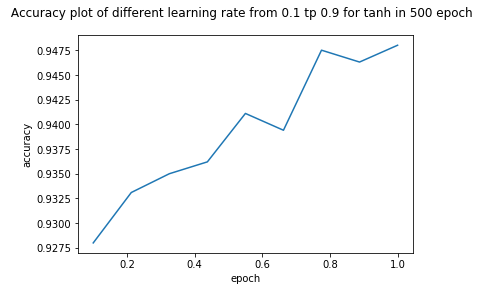

In [0]:
# Accuracy plot of different learning rate from 0.1 tp 0.9 for tanh in 500 epoch
plt.plot(np.linspace(0.1,1,9),accuracy_tanh_q1[0:9])
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.suptitle(' Accuracy plot of different learning rate from 0.1 tp 0.9 for {} {} hidden layer'.format(str(conf.activations[0]),str(conf.hidden_layers[0])))
plt.show()

<b>Relu:</b>

In [0]:

#update config
number_of_epoch = 200 #more epoch trying to get best results
conf.activations = ["relu"]
conf.hidden_layers = [300]

#initialize model
tensorNN = TensorflowNN(conf)

#initialize output
accuracy_relu_q1 = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve_relu_q1 = np.zeros((10,number_of_epoch))

for i in range(1,10):
  learning_curve_relu_q1[i-1],accuracy_relu_q1[i-1] = training(i/10,conf,number_of_epoch)
  #print("accuracy: ",learning_curve[i-1])
  #print("accuracy:",accuracy_relu_q1[i-1])

learning rate: 0.1
accuracy: 0.75
learning rate: 0.2
accuracy: 0.7582
learning rate: 0.3
accuracy: 0.761
learning rate: 0.4
accuracy: 0.9674
learning rate: 0.5
accuracy: 0.9673
learning rate: 0.6
accuracy: 0.972
learning rate: 0.7
accuracy: 0.9734
learning rate: 0.8
accuracy: 0.9751
learning rate: 0.9
accuracy: 0.8764


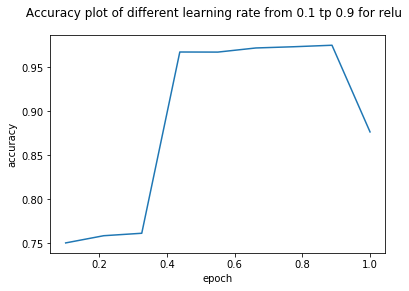

In [0]:
# Accuracy plot of different learning rate from 0.1 tp 0.9 for relu
plt.plot(np.linspace(0.1,1,9),accuracy[0:9])
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.suptitle(' Accuracy plot of different learning rate from 0.1 tp 0.9 for {} {} hidden layer'.format(str(conf.activations[0]),str(conf.hidden_layers[0])))
plt.show()

In [0]:

#update config
number_of_epoch = 200 #more epoch trying to get best results
conf.activations = ["sigmoid"]
conf.hidden_layers = [10]

#initialize model
tensorNN = TensorflowNN(conf)

#initialize output
accuracy = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve = np.zeros((10,number_of_epoch))

for i in range(1,10):
  learning_curve[i-1],accuracy[i-1] = training(i/10,conf,number_of_epoch)
  #print("accuracy: ",learning_curve[i-1])
  print("accuracy:",accuracy[i-1])

learning rate: 0.1
accuracy: 0.9468
learning rate: 0.2
accuracy: 0.952
learning rate: 0.3
accuracy: 0.9544
learning rate: 0.4
accuracy: 0.9559
learning rate: 0.5
accuracy: 0.9566
learning rate: 0.6
accuracy: 0.956
learning rate: 0.7
accuracy: 0.9563
learning rate: 0.8
accuracy: 0.9573
learning rate: 0.9
accuracy: 0.9578


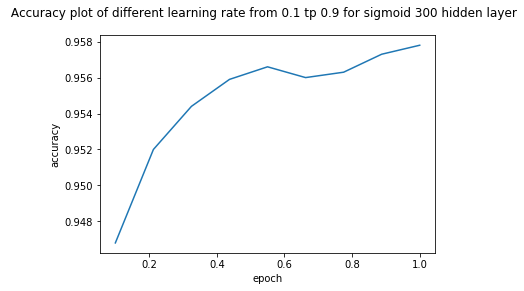

In [0]:
 # Accuracy plot of different learning rate from 0.1 tp 0.9 for sigmoid
plt.plot(np.linspace(0.1,1,9),accuracy[0:9])
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.suptitle(' Accuracy plot of different learning rate from 0.1 tp 0.9 for {} {} hidden layer'.format(str(conf.activations[0]),str(conf.hidden_layers[0])))
plt.show()

learning rate: 0.1
learning rate: 0.2
learning rate: 0.3
learning rate: 0.4
learning rate: 0.5
learning rate: 0.6
learning rate: 0.7
learning rate: 0.8
learning rate: 0.9


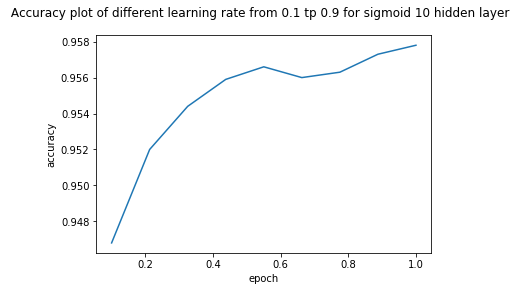

In [0]:

#update config
number_of_epoch = 200 #more epoch trying to get best results
conf.activations = ["sigmoid"]
conf.hidden_layers = [10]

#initialize model
tensorNN = TensorflowNN(conf)

#initialize output
accuracy = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve = np.zeros((10,number_of_epoch))

for i in range(1,10):
  learning_curve[i-1],accuracy[i-1] = training(i/10,conf,number_of_epoch)
  #print("accuracy: ",learning_curve[i-1])
  #print("accuracy:",accuracy[i-1])
  
 # Accuracy plot of different learning rate from 0.1 tp 0.9 for sigmoid
plt.plot(np.linspace(0.1,1,9),accuracy[0:9])
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.suptitle(' Accuracy plot of different learning rate from 0.1 tp 0.9 for {} {} hidden layer'.format(str(conf.activations[0]),str(conf.hidden_layers[0])))
plt.show()

learning rate: 0.1
learning rate: 0.2
learning rate: 0.3
learning rate: 0.4
learning rate: 0.5
learning rate: 0.6
learning rate: 0.7
learning rate: 0.8
learning rate: 0.9


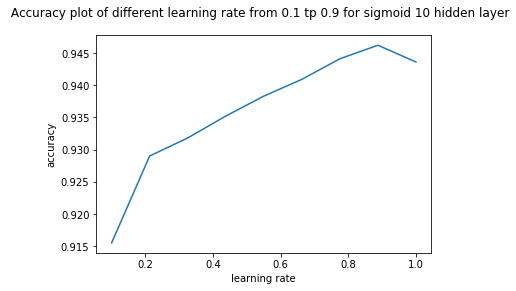

In [0]:

#update config
number_of_epoch = 20
conf = Conf(hidden_layers=[30],
           activations=["sigmoid"],
           learning_rate=0.1)

#initialize model
tensorNN = TensorflowNN(conf)

#initialize output
accuracy = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve = np.zeros((10,number_of_epoch))

for i in range(1,10):
  learning_curve[i-1],accuracy[i-1] = training(i/10,conf,number_of_epoch)
  #print("accuracy: ",learning_curve[i-1])
  #print("accuracy:",accuracy[i-1])
  
# Accuracy plot of different learning rate from 0.1 tp 0.9 for sigmoid
plt.plot(np.linspace(0.1,1,9),accuracy[0:9])
plt.ylabel('accuracy')
plt.xlabel('learning rate')
plt.suptitle(' Accuracy plot of different learning rate from 0.1 to 0.9 for {} {} hidden layer'.format(str(conf.activations[0]),str(conf.hidden_layers[0])))
plt.show()

### Question 1 Answer:

The best accuracy I got is about 0.972 with relu and learning rate between 0.4 to 0.9 with 300 hidden layers

### Question 2

<li> Does scaling down the initial parameters affect the learning curve? In other words, you use ``np.random.randn(prev,curr)/K``(K>>1) instead of ``np.random.randn(prev,curr)``. Did you observe this uniformly across sigmoid, tanh and relu? Did you find any correlation with the number of hidden units? Explain. </li>

<b>New config for scaling down weights</b>

In [0]:
class Conf:
    def __init__(self,hidden_layers,activations,learning_rate,scale_factor):
        self.hidden_layers = hidden_layers
        self.scale_factor = scale_factor
        number_units = [784] + hidden_layers + [10]
        weights = []
        biases = []
        for prev,curr in zip(number_units,number_units[1:]):
            np.random.seed(1)
            weights.append(np.random.randn(prev,curr)/scale_factor)
            biases.append(np.zeros([1,curr],dtype=np.float32))
        self.weights = weights
        self.biases = biases
        self.activations = activations
        self.learning_rate = learning_rate

In [0]:
def training_q2(num_epoch,lr,activation,layers,k):
  # initialize conf
  conf = Conf(hidden_layers=layers,
             activations=activation,
             learning_rate=lr,
             scale_factor = k)

  #print("Scaling:",conf.scale_factor)
  tensorNN = TensorflowNN(conf)
  accuracy = np.zeros(num_epoch)
  
  for epoch in range(num_epoch):
      for idx in range(0,train_data.shape[0],128):
          # TensorNN update
          tensorNN.apply_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
      tensorNN_correct = 0
      for idx in range(0,eval_data.shape[0],128):
          expected = eval_labels[idx:idx+128]

          # TensorNN Accuracy
          preds = tensorNN.forward(eval_data[idx:idx+128])
          tensorNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()

      #print("Epoch {}: {}".format(epoch,tensorNN_correct/eval_data.shape[0]))
      accuracy[epoch] = tensorNN_correct/eval_data.shape[0]
  return accuracy,accuracy[-1]

<b> Start experiment</b>

In [0]:
#initialize output
accuracy_tanh_scaled_q2 = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve_tanh_scaled_q2 = np.zeros((10,number_of_epoch))

number_of_epoch = 10
lr = 0.1
activation = ["sigmoid"]
hidden_layers = [300]

for i in range(1,10):
  learning_curve_tanh_scaled_q2[i-1],accuracy_tanh_scaled_q2[i-1] = training_q2(number_of_epoch, lr, activation, hidden_layers, i)
  #print("accuracy: ",learning_curve[i-1])
  #print("accuracy:",accuracy_tanh_scaled_q2[i-1])

Scaling: 1
Scaling: 2
Scaling: 3
Scaling: 4
Scaling: 5
Scaling: 6
Scaling: 7
Scaling: 8
Scaling: 9


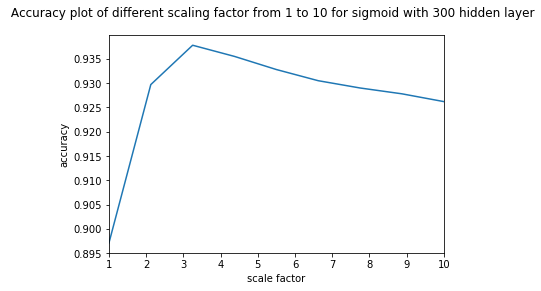

In [0]:
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2[0:9])
plt.ylabel('accuracy')
plt.xlabel('scale factor')
plt.xlim((1,10))
plt.suptitle(' Accuracy plot of different scaling factor from 1 to 10 for {} with {} hidden layer'.format(str(activation[0]),str(hidden_layers[0])))
plt.show()

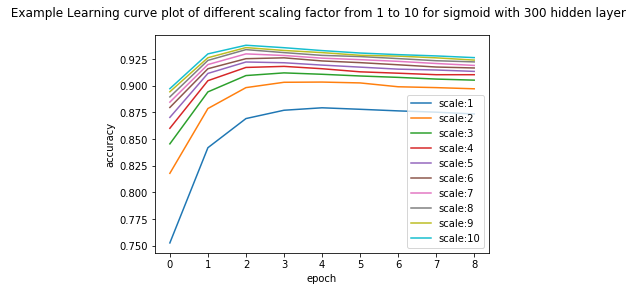

In [0]:
plt.plot(learning_curve_tanh_scaled_q2[0:9])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.suptitle(' Example Learning curve plot of different scaling factor from 1 to 10 for {} with {} hidden layer'.format(str(activation[0]),str(hidden_layers[0])))
plt.legend(['scale:1','scale:2','scale:3','scale:4','scale:5','scale:6','scale:7','scale:8','scale:9','scale:10'])
plt.show()

<b>Increase number of hidden layer</b>

In [0]:
#initialize output
accuracy_tanh_scaled_q2_2 = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve_tanh_scaled_q2_2 = np.zeros((10,number_of_epoch))

number_of_epoch = 10
lr = 0.1
activation = ["sigmoid"]
hidden_layers = [500]

for i in range(1,10):
  learning_curve_tanh_scaled_q2_2[i-1],accuracy_tanh_scaled_q2_2[i-1] = training_q2(number_of_epoch, lr, activation, hidden_layers, i)
  #print("accuracy: ",learning_curve[i-1])
  #print("accuracy:",accuracy_tanh_scaled_q2_2[i-1])

Scaling: 1
Scaling: 2
Scaling: 3
Scaling: 4
Scaling: 5
Scaling: 6
Scaling: 7
Scaling: 8
Scaling: 9


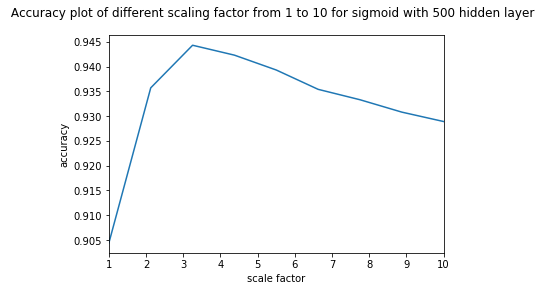

In [0]:
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2_2[0:9])
plt.ylabel('accuracy')
plt.xlabel('scale factor')
plt.xlim((1,10))
plt.suptitle(' Accuracy plot of different scaling factor from 1 to 10 for {} with {} hidden layer'.format(str(activation[0]),str(hidden_layers[0])))
plt.show()

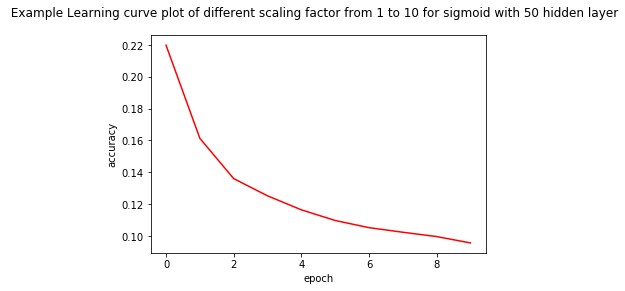

In [0]:
plt.plot(1-learning_curve_tanh_scaled_q2_2[0],color = 'red')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.suptitle(' Example Learning curve plot of different scaling factor from 1 to 10 for {} with {} hidden layer'.format(str(activation[0]),str(hidden_layers[0])))
#plt.legend(['scale:1','scale:2','scale:3','scale:4','scale:5','scale:6','scale:7','scale:8','scale:9','scale:10'])
plt.show()

In [0]:
#initialize output
accuracy_tanh_scaled_q2_3 = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve_tanh_scaled_q2_3 = np.zeros((10,number_of_epoch))

number_of_epoch = 10
lr = 0.1
activation = ["sigmoid"]
hidden_layers = [50]

for i in range(1,10):
  learning_curve_tanh_scaled_q2_3[i-1],accuracy_tanh_scaled_q2_3[i-1] = training_q2(number_of_epoch, lr, activation, hidden_layers, i)
  #print("accuracy: ",learning_curve[i-1])
  #print("accuracy:",accuracy_tanh_scaled_q2_2[i-1])

Scaling: 1
Scaling: 2
Scaling: 3
Scaling: 4
Scaling: 5
Scaling: 6
Scaling: 7
Scaling: 8
Scaling: 9


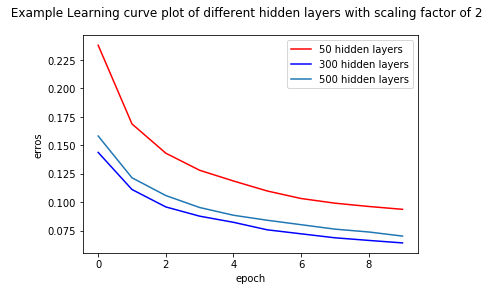

In [0]:
plt.plot(1-learning_curve_tanh_scaled_q2_3[1],color = 'red')
plt.plot(1-learning_curve_tanh_scaled_q2_2[1],color = 'blue')
plt.plot(1-learning_curve_tanh_scaled_q2[1])
plt.ylabel('erros')
plt.xlabel('epoch')
plt.suptitle(' Example Learning curve plot of different hidden layers with scaling factor of 2')
plt.legend(['50 hidden layers', '300 hidden layers','500 hidden layers'])
plt.show()

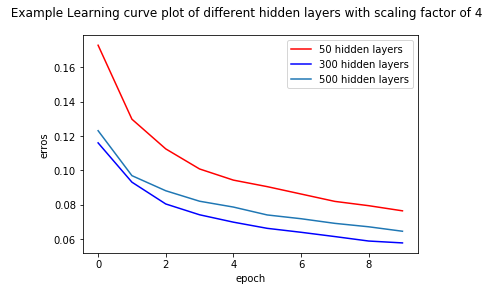

In [0]:
plt.plot(1-learning_curve_tanh_scaled_q2_3[3],color = 'red')
plt.plot(1-learning_curve_tanh_scaled_q2_2[3],color = 'blue')
plt.plot(1-learning_curve_tanh_scaled_q2[3])
plt.ylabel('erros')
plt.xlabel('epoch')
plt.suptitle(' Example Learning curve plot of different hidden layers with scaling factor of 4')
plt.legend(['50 hidden layers', '300 hidden layers','500 hidden layers'])
plt.show()

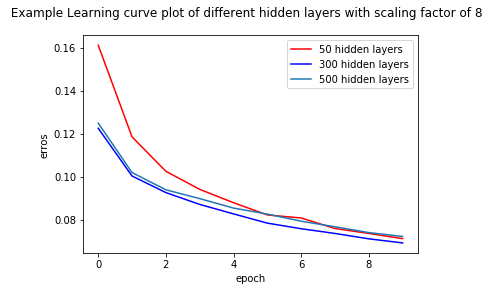

In [0]:
plt.plot(1-learning_curve_tanh_scaled_q2_3[7],color = 'red')
plt.plot(1-learning_curve_tanh_scaled_q2_2[7],color = 'blue')
plt.plot(1-learning_curve_tanh_scaled_q2[7])
plt.ylabel('erros')
plt.xlabel('epoch')
plt.suptitle(' Example Learning curve plot of different hidden layers with scaling factor of 8')
plt.legend(['50 hidden layers', '300 hidden layers','500 hidden layers'])
plt.show()

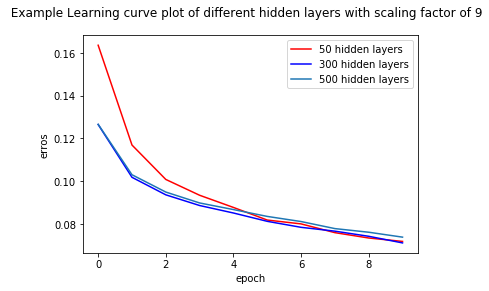

In [0]:
plt.plot(1-learning_curve_tanh_scaled_q2_3[8],color = 'red')
plt.plot(1-learning_curve_tanh_scaled_q2_2[8],color = 'blue')
plt.plot(1-learning_curve_tanh_scaled_q2[8])
plt.ylabel('erros')
plt.xlabel('epoch')
plt.suptitle(' Example Learning curve plot of different hidden layers with scaling factor of 9')
plt.legend(['50 hidden layers', '300 hidden layers','500 hidden layers'])
plt.show()

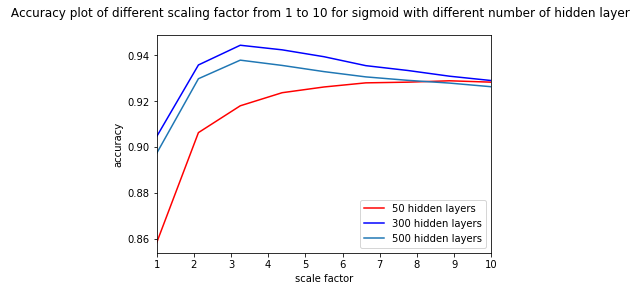

In [0]:
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2_3[0:9],color = 'red')
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2_2[0:9],color = 'blue')
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2[0:9])

plt.ylabel('accuracy')
plt.xlabel('scale factor')
plt.xlim((1,10))
plt.suptitle(' Accuracy plot of different scaling factor from 1 to 10 for {} with different number of hidden layer'.format(str(activation[0])))
plt.legend(['50 hidden layers', '300 hidden layers','500 hidden layers'])
plt.show()

In [0]:
#initialize output
accuracy_tanh_scaled_q2_4 = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve_tanh_scaled_q2_4 = np.zeros((10,number_of_epoch))

number_of_epoch = 10
lr = 0.1
activation = ["sigmoid"]
hidden_layers = [150]

for i in range(1,10):
  learning_curve_tanh_scaled_q2_4[i-1],accuracy_tanh_scaled_q2_4[i-1] = training_q2(number_of_epoch, lr, activation, hidden_layers, i)
  #print("accuracy: ",learning_curve[i-1])
  #print("accuracy:",accuracy_tanh_scaled_q2_2[i-1])

Scaling: 1
Scaling: 2
Scaling: 3
Scaling: 4
Scaling: 5
Scaling: 6
Scaling: 7
Scaling: 8
Scaling: 9


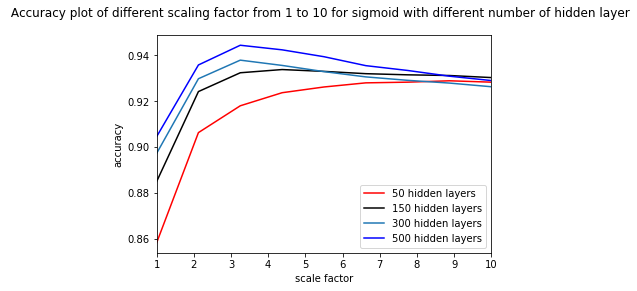

In [0]:
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2_3[0:9],color = 'red')
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2_4[0:9],color = 'black')
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2[0:9])
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q2_2[0:9],color = 'blue')


plt.ylabel('accuracy')
plt.xlabel('scale factor')
plt.xlim((1,10))
plt.suptitle(' Accuracy plot of different scaling factor from 1 to 10 for {} with different number of hidden layer'.format(str(activation[0])))
plt.legend(['50 hidden layers','150 hidden layers', '300 hidden layers' ,'500 hidden layers'])
plt.show()

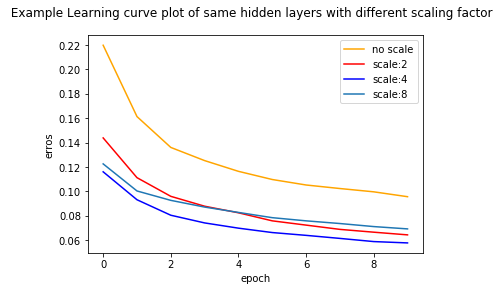

In [0]:
plt.plot(1-learning_curve_tanh_scaled_q2_2[0],color = 'orange')
plt.plot(1-learning_curve_tanh_scaled_q2_2[1],color = 'red')
plt.plot(1-learning_curve_tanh_scaled_q2_2[3],color = 'blue')
plt.plot(1-learning_curve_tanh_scaled_q2_2[7])

plt.ylabel('erros')
plt.xlabel('epoch')
plt.suptitle(' Example Learning curve plot of same hidden layers with different scaling factor')
plt.legend(['no scale','scale:2', 'scale:4','scale:8'])
plt.show()

###Question 2 Answer:

Yes, scale down the weights does have improvements on learning curve. One possible reason is that by scaling down the weights the network will not compute(learns) large gradients. In other words a network with large weights is not stable.

For sigmoid the correlation of scaling factor and hidden layers is when the scale factor is low, for example the above graph show that with 50 hidden layer the model tends to learn faster. And the numner of hidden layer increases the model learns much slower. 
 

###Question 3

<li> Did you come across any configurations which got stuck in a saddle point and progressed very slowly, yielding a below-normal accuracy in about 50 epochs (despite adjusting the learning-rate)? These networks can be trained better by the use of Momentum. Implement an additional method in the CustomNN class which can perform the momentum update. Use the TensorflowNN class to validate your code; you can add another optimizer object to the TensorflowNN class. Add an additional attribute to the Conf class that controls the momentum. </li>

In [0]:
class CustomNN_momentum:
    def __init__(self,conf):
        self.weights = [cad.Variable(weight) for weight in conf.weights]
        self.biases = [cad.Variable(bias) for bias in conf.biases]
        self.activations = [activation_map[activation][0] for activation in conf.activations]
        self.learning_rate = conf.learning_rate
        self.mu = conf.momentum
        
    def forward(self,batch):

        temp = cad.Variable(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        logits = temp@self.weights[-1]+self.biases[-1]
        softmax = logits.exp()/logits.exp().reduce_sum(axis=1)
        return logits.value
    
    def loss_and_gradients(self,batch,targets):
        for param in self.weights+self.biases:
            param.reset()
            
        temp = cad.Variable(batch)
        for weight,bias,act in zip(self.weights,self.biases,self.activations):
            temp = temp@weight+bias
            temp = act(temp)
        
        logits = temp@self.weights[-1]+self.biases[-1]
        

        logits = logits + (-logits.value.max(axis=1,keepdims=True))
        softmax = logits.exp()/logits.exp().reduce_sum(axis=1)
        

        loss = ((softmax+10**-6).log() * cad.Variable(-targets)).reduce_sum(axis=0).reduce_sum(axis=1)/batch.shape[0]
        
        loss.gradient = 1
        loss.backward()
        return {
            "loss" :loss.value,
            "grads":[param.gradient for param in (self.weights+self.biases)]
        }
    
    def apply_gradients(self):
        #initial velocity is zero
        v = 0
        for param in self.weights+self.biases:
            param.value -= self.learning_rate * param.gradient
            print('para',np.shape(param.value))
            
            '''
            # Momentum update
            p ← μp − α∇θ 
            θ ← θ + p
            '''
            a = self.learning_rate * param.gradient
            b = self.mu * v
            print('shape',np.shape(a),np.shape(b))
            v = np.subtract(b , a)
            #param.value += v
            param.reset()

In [0]:
class TensorflowNN_momentum:
    def __init__(self,conf):
        # Why is it a good idea to build the compute graph within the tf.Graph scope?
        '''
        1: Tensorflow's session will caches information about the graph
        2: For parallesims, differetn part of the graph can run in parallel to save computation time. 
        '''
        g = tf.Graph()
        with g.as_default():
            # Define the placeholders
            self.input = tf.placeholder(dtype=tf.float64, shape=(None, 784))
            self.expected_output = tf.placeholder(dtype=tf.float64, shape=(None, 10))
            
            self.weights = [tf.Variable(dtype=tf.float64,initial_value=weight) for weight in conf.weights]
            self.biases = [tf.Variable(dtype=tf.float64,initial_value=bias) for bias in conf.biases]

            # Build the graph for computing output.
            layer = self.input
            for i in range(0, len(conf.activations)):
                layer = layer@self.weights[i] + self.biases[i]
                layer = activation_map[conf.activations[i]][1](layer)
            
            # For output layer
            self.logits = layer@self.weights[-1] + self.biases[-1]
            logits = self.logits - tf.reduce_max(self.logits,axis=1,keepdims=True)
            
            self.output = tf.exp(logits)/tf.reduce_sum(tf.exp(logits),axis=1,keepdims=True)
            self.loss = -tf.reduce_mean(tf.reduce_sum(tf.log(self.output+10**-6)*self.expected_output,axis=1))
            
            # Instantiate the optimizer
            #self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=conf.learning_rate)
            self.optimizer = tf.train.MomentumOptimizer(learning_rate=conf.learning_rate, momentum = conf.momentum, use_nesterov=False)
            
            self.grads = self.optimizer.compute_gradients(self.loss)
            self.train_op = self.optimizer.apply_gradients(self.grads)
            
            self.session = tf.Session()
            
            # Initialize all variables
            self.session.run(tf.global_variables_initializer())
    
    def forward(self,batch):
        return self.session.run(self.logits,feed_dict={self.input:batch})
    
    def loss_and_gradients(self,batch,targets):
        return {
            "loss" :self.session.run(self.loss,feed_dict={self.input:batch,self.expected_output:targets}),
            "grads":self.session.run(tf.gradients(self.loss,self.weights+self.biases),feed_dict={self.input:batch,self.expected_output:targets})
        }
    
    def apply_gradients(self,batch,targets):
        self.session.run(self.train_op,feed_dict={self.input:batch,self.expected_output:targets})

In [0]:
class Conf:
    def __init__(self,hidden_layers,activations,learning_rate,scale_factor,momentum):
        self.hidden_layers = hidden_layers
        self.scale_factor = scale_factor
        number_units = [784] + hidden_layers + [10]
        weights = []
        biases = []
        for prev,curr in zip(number_units,number_units[1:]):
            np.random.seed(1)
            weights.append(np.random.randn(prev,curr)/scale_factor)
            biases.append(np.zeros([1,curr],dtype=np.float32))
        self.weights = weights
        self.biases = biases
        self.activations = activations
        self.learning_rate = learning_rate
        self.momentum = momentum

conf = Conf(hidden_layers=[300],
           activations=["sigmoid"],
           learning_rate=0.1,
           scale_factor = 1,
           momentum = 0)
        
        
customNN = CustomNN_momentum(conf)
tensorNN = TensorflowNN_momentum(conf)

<b>Compare to tensorflow implementation</b>

In [0]:
for epoch in range(10):
    for idx in range(0,train_data.shape[0],128):
        # TensorNN update
        tensorNN.apply_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
        
        # CustomNN update
        loss_and_grads1 = customNN.loss_and_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
        customNN.apply_gradients()
    
    tensorNN_correct = 0
    customNN_correct = 0
    for idx in range(0,eval_data.shape[0],128):
        expected = eval_labels[idx:idx+128]
        
        # TensorNN Accuracy
        preds = tensorNN.forward(eval_data[idx:idx+128])
        tensorNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()
        
        # CustomNN Accuracy
        preds = customNN.forward(eval_data[idx:idx+128])
        customNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()
    
    print("Epoch {}: {} {}".format(epoch,tensorNN_correct/eval_data.shape[0],customNN_correct/eval_data.shape[0]))

para (784, 300)
shape (784, 300) ()
para (300, 10)
shape (300, 10) (784, 300)


ValueError: ignored

In [0]:
def training_q3(num_epoch,lr,activation,layers,k,mu):
  # initialize conf
  conf = Conf(hidden_layers=layers,
             activations=activation,
             learning_rate=lr,
             scale_factor = k,
             momentum = mu)

  #print("Scaling:",conf.scale_factor)
  tensorNN = TensorflowNN(conf)
  accuracy = np.zeros(num_epoch)
  
  for epoch in range(num_epoch):
      for idx in range(0,train_data.shape[0],128):
          # TensorNN update
          tensorNN.apply_gradients(train_data[idx:idx+128],train_labels[idx:idx+128])
      tensorNN_correct = 0
      for idx in range(0,eval_data.shape[0],128):
          expected = eval_labels[idx:idx+128]

          # TensorNN Accuracy
          preds = tensorNN.forward(eval_data[idx:idx+128])
          tensorNN_correct += (np.argmax(preds,axis=1)==np.argmax(expected,axis=1)).sum()

      #print("Epoch {}: {}".format(epoch,tensorNN_correct/eval_data.shape[0]))
      accuracy[epoch] = tensorNN_correct/eval_data.shape[0]
  return accuracy,accuracy[-1]

In [0]:
#initialize output
accuracy_tanh_scaled_q3 = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve_tanh_scaled_q3 = np.zeros((10,number_of_epoch))

number_of_epoch = 10
lr = 0.1
activation = ["sigmoid"]
hidden_layers = [300]
scale_factor = 4
momentum = 0.9

for i in range(1,2):
  learning_curve_tanh_scaled_q3[i-1],accuracy_tanh_scaled_q3[i-1] = training_q2(number_of_epoch, lr, activation, hidden_layers, scale_factor, momentum)
  #print("accuracy: ",learning_curve[i-1])
  #print("accuracy:",accuracy_tanh_scaled_q2[i-1])

In [0]:
plt.plot(np.linspace(1,10,9),accuracy_tanh_scaled_q3[0:9])
plt.ylabel('accuracy')
plt.xlabel('scale factor')
plt.xlim((1,10))
plt.suptitle(' Accuracy plot of different scaling factor from 1 to 10 for {} with {} hidden layer'.format(str(activation[0]),str(hidden_layers[0])))
plt.show()

### Question 3 Answer:



Yes slow progress in 50 epochs when learning rate is 0.1~0.3 or greater than 0.8 with relu activation function. The accuracy is 0.75 which seems stuck at a saddle point or a local minimal. 


### Question 4

<li> For only one such configuration, demonstrate the improvement that you can get by using momentum by plotting the learning curve. </li> 

###Question 5

<li> What was the best accuracy you were able to get in 10 epochs of training? What was the corresponding config?</li>

In [0]:
class Conf:
    def __init__(self,hidden_layers,activations,learning_rate,scale_factor):
        self.hidden_layers = hidden_layers
        self.scale_factor = scale_factor
        number_units = [784] + hidden_layers + [10]
        weights = []
        biases = []
        for prev,curr in zip(number_units,number_units[1:]):
            np.random.seed(1)
            weights.append(np.random.randn(prev,curr)/scale_factor)
            biases.append(np.zeros([1,curr],dtype=np.float32))
        self.weights = weights
        self.biases = biases
        self.activations = activations
        self.learning_rate = learning_rate

In [0]:
#initialize output
accuracy_tanh_scaled_q5 = np.zeros(number_of_epoch) #array store accuracy score for different learning rate 
learning_curve_tanh_scaled_q5 = np.zeros((10,number_of_epoch))

number_of_epoch = 10
lr = 0.9
activation = ["relu"]
hidden_layers = [500]
scale_factor = 20

for i in range(1,2):
  learning_curve_tanh_scaled_q5[i-1],accuracy_tanh_scaled_q5[i-1] = training_q2(number_of_epoch, lr, activation, hidden_layers, scale_factor)
  #print("accuracy: ",learning_curve[i-1])
  print("accuracy:",accuracy_tanh_scaled_q5[i-1])

Scaling: 20
accuracy: 0.9812


In [0]:
# best config accuracy is 0.9812
lr = 0.9
activation = ["relu"]
hidden_layers = [500]
scale_factor = 20

In [0]:
conf = None